In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.lines import Line2D
from scipy.integrate import odeint
from sympy import *
from sympy.utilities.autowrap import autowrap
import numpy as np
import time
import itertools
import re
import sys
import pandas as pd
from scipy.io import loadmat, savemat
import seaborn as sns

%matplotlib inline

In [2]:
###################################################
# Part I - Define the paths to the data and ODEs
###################################################
# Define the path to the input folder containing the output parameters
inputFolder = "/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Output/M019/CDDP/20220314_111222/"
#inputFolder = "/Users/murielheldring/TransferredFiles/M056/CDDP/20191205/Run1/" # Write down the path to the folder that
# contains the parameter estimates of all the finished runs

# Define the path to the ode system file
odeModelFolder = "/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/" # Write down the path to the folder that
# contains the file with the ODE system

# Define the path to the data file
dataFolder = "/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/" # Write down the path to the folder that
# contains the file with the data

fileName = "20220314_111222_MH_M019Model_parameterEstimates_parmset3_cost_80.80.csv"

figOutputPath = "/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Notebooks/Figures/"


In [3]:
# Get the date, treatment and model name from the path
date = str.split(inputFolder,"/")[-2]
trmnt = str.split(inputFolder,"/")[-3]
model = str.split(inputFolder,"/")[-4]

# Read in the metadata from the metadata.txt file
with open(inputFolder + "metadata.txt") as f:
    lines = f.readlines()
    for line in lines:
        print(line)
        exec(line)

# Read in the parameters from a file
try:
    fh = open(odeModelFolder + odeFile, 'r')
    print("Path to text file with ODEs and parms exists")
    with open(odeModelFolder + odeFile) as f:
        lines = f.readlines()
    startReading = False
    stopReading = False

    print("The system parameters:")
    for i, line in enumerate(lines):
        if "####START_PARAMETERS####\n" == lines[i - 1]:
            startReading = True
        elif "####END_PARAMETERS####\n" == line:
            stopReading = True

        if startReading and not stopReading:
            print(line)
            exec(line)
except FileNotFoundError:
    sys.exit("Path to text file with ODEs and parameters does not exist.")

# Read in the settings from the settings.txt file
with open(inputFolder + "settings.txt") as g:
    lines = g.readlines()
    for line in lines:
        print(line)
        exec(line)

# Define paths to data
allDataFiles = os.listdir(inputFolder)
# Select the parameter files
parFiles = []
for file in allDataFiles:
    # if str.split(file,".")[-1] == "csv":
    if re.search(".\d{2}.csv", file): #str.split(file, ".")[-1] == "csv":
        parFiles = parFiles + [file]
print("These files will be read: \n%s" % (',\n'.join([str(i) for i in parFiles])))

# Paths to output folder
pathToOutput = inputFolder

# Read in the ODEs from a file
try:
    fh = open(odeModelFolder + odeFile, 'r')
    print("Path to text file with ODEs exists")
    with open(odeModelFolder + odeFile) as f:
        lines = f.readlines()
    startReading = False
    stopReading = False
    # Make a dictionary that will contain the ODEs as specified in the file
    odeDict = {}
    obsDict = {}
    print("The system of ODES:")
    for i, line in enumerate(lines):
        if "####START_ODES####\n" == lines[i - 1]:
            startReading = True
        elif "####END_ODES####\n" == line:
            stopReading = True

        if startReading and not stopReading:
            print(line)
            exec(line)
            # Make a dictionary that contains the ODEs
            # It is a match if the first chars of line are f0, f1, ..., fn
            match = re.search('^f[0-9]+', line)
            if match:
                parts = line.split(" = ")
                odeDict[parts[0]] = parts[1][:-1]

            # Make a dictionary that contains the observables
            # It is a match if the first chars of line are g0, g1, ..., gn
            match = re.search('^g[0-9]+', line)
            if match:
                parts = line.split(" = ")
                obsDict[parts[0]] = parts[1][:-1]
except FileNotFoundError:
    sys.exit("Path to text file with ODEs does not exist.")


#palette = ["steelblue","steelblue","steelblue","steelblue","r","g"]



MODEL = "M019"

DATETIME = "20220314_111222"

pathToInputFolder = "Input/withRNA/"

dataFile = "20201006_MH_CDDPdata_wFUCCI_DDP.csv"

pathToData = "Input/withRNA/20201006_MH_CDDPdata_wFUCCI_DDP.csv"

odeFile = "M019_20220311_ODE_p53model.txt"

pathToODEs = "Input/withRNA/M019_20220311_ODE_p53model.txt"

pathToOutput = "/data/muriel/Projects/PHH/Modeling/Output//M019/"

NiniP = 15

Ncpu = 15

Path to text file with ODEs and parms exists
The system parameters:


# Fixed/known parameters or initial states (optional)

# Example: < A_init = 0.1 

#            conc1 = 0 >

#

EC1 = 1

kd_p53rna = 1

P53rna_init = 1

MDM2rna_init = 1

P21rna_init = 1

BTG2rna_init = 1

P53_init = 1

MDM2_init = 1

P21_init = 1

BTG2_init = 1

kd_btg2 = 1

kd_p21 = 1

kd_mdm2 = 1



# Name of stress as it occurs in the ODE functions; either stressName = ['your stress input name'], i.e. your stress name as list, 

# or set as empty list, i.e. stressName = [], if there is no model perturbation.

# Example: < str

Stress = exposurePiecewise * Piecewise((1, (tsym > 0)), (0,True))

Stressautowrap = eval('autowrap(Stress, backend = "cython", args = (ks_dd, ks_p53rna, k_p, ks_p53, kd_mdm2rna, ks_mdm2, kd_p21rna, ks_p21, kd_btg2rna, ks_btg2, EC2, EC3, tau1, kd_dd, k_dp, kd_p53, kd_p53p, kd_p53_mdm2, kd_p53p_mdm2, ks_mdm2rna, ks_mdm2_p53p, ks_p21rna, ks_p21_p53p, Km_mdm2, Km_p21, Km_btg2, ks_btg2rna, ks_btg2_p53p, sf_p53, sf_mdm2, sf_p21, sf_btg2, offset_p53, offset_mdm2, offset_p21, offset_btg2, tsym, dose))')

These files will be read: 
20220314_111222_MH_M019Model_parameterEstimates_parmset1_cost_27442.21.csv,
20220314_111222_MH_M019Model_parameterEstimates_parmset13_cost_80.80.csv,
20220314_111222_MH_M019Model_parameterEstimates_parmset10_cost_2076.53.csv,
20220314_111222_MH_M019Model_parameterEstimates_parmset14_cost_24948.56.csv,
20220314_111222_MH_M019Model_parameterEstimates_parmset2_cost_199.38.csv,
20220314_111222_MH_M019Model_parameterEstimates_parmset11_cost_27416.40.csv,
20220314_111222_M

In [4]:
Nt = 43
tspan = np.arange(0, Nt, 1)

In [5]:
# Read in the data
data = pd.read_csv(dataFolder + dataFile)

# Make a separate dataTemp data frame per cell line, because every cell line can have a different number
# of replicates and save those data frames in a list:
dfListInterpol = []
dfListReal = []
dfListTimeInterpol = []
dfListTimeReal = []
# Loop over the reporters
for cell_linei, celllinet in enumerate(obsStateVarList):
    # Create NrOfDoses matrices with NrOfReplicates rows and NrOfTimepoints columns
    # For example: 22 time points, 3 replicates, 4 reporter cell lines, 5 doses
    dataTempInterpol = np.zeros((len(doseList), len(plateID_list[cell_linei]), Nt))
    dataTempReal = np.zeros((len(doseList), len(plateID_list[cell_linei]), Nt))
    dataTempTimeInterpol = np.zeros((len(doseList), len(plateID_list[cell_linei]), Nt))
    dataTempTimeReal = np.zeros((len(doseList), len(plateID_list[cell_linei]), Nt))

    # Loop over the doses
    for dosei, stresslevel in enumerate(doseList):

        # Loop over the replicates
        for replicatei, replicateID in enumerate(plateID_list[cell_linei]):

            # Loop over the time points
            for tpi in np.arange(0, Nt, 1):
                timeIDinData = tpi + 1
                datasample = data[(data.StateVar == celllinet) & (data.replID == replicateID) &
                                  (data.dose_uMadj == stresslevel) & (data.timeID == timeIDinData)]
                # datasample = data[(data.protein == celllinet) & (data.replID == replicateID) &
                #                   (data.dose_uMadj == stresslevel) & (data.timeID == timeIDinData)]

                dataTempReal[dosei, replicatei, tpi] = datasample[realDataColName]
                dataTempInterpol[dosei, replicatei, tpi] = datasample[interpolDataColName]
                dataTempTimeReal[dosei, replicatei, tpi] = datasample[realTimeColName]
                dataTempTimeInterpol[dosei, replicatei, tpi] = datasample[interpolTimeColName]
    dfListInterpol.append(dataTempInterpol)
    dfListReal.append(dataTempReal)
    dfListTimeInterpol.append(dataTempTimeInterpol)
    dfListTimeReal.append(dataTempTimeReal)

dfListMeanReal = []
dfListStdReal = []
dfListMean = []
dfListStd = []
dfListTimeMeanReal = []
dfListTimeStdReal = []
dfListTimeMean = []
dfListTimeStd = []
# Loop over the dataframes, i.e. the cell lines
for cell_linei, celllinet in enumerate(obsStateVarList):
    df = dfListInterpol[cell_linei]
    dfReal = dfListReal[cell_linei]
    dfTime = dfListTimeInterpol[cell_linei]
    dfTimeReal = dfListTimeReal[cell_linei]

    dfTemp = np.array([]).reshape(len(plateID_list[cell_linei]), 0)
    dfTempReal = np.array([]).reshape(len(plateID_list[cell_linei]), 0)
    dfTempTime = np.array([]).reshape(len(plateID_list[cell_linei]), 0)
    dfTempTimeReal = np.array([]).reshape(len(plateID_list[cell_linei]), 0)
    for dosei in np.arange(0, len(doseList), 1):
        # Bind the doses horizontally to obtain a NrOfReplicates x (NrOfDoses x NrOfTimepoints) matrix
        dfTemp = np.hstack((dfTemp, df[dosei]))
        dfTempReal = np.hstack((dfTempReal, dfReal[dosei]))
        dfTempTime = np.hstack((dfTempTime, dfTime[dosei]))
        dfTempTimeReal = np.hstack((dfTempTimeReal, dfTimeReal[dosei]))

    # Calculate the mean and std per column, i.e. the mean and std of the replicates
    dfTempM = np.mean(dfTemp, axis=0)
    dfTempS = np.std(dfTemp, axis=0)
    dfTempMReal = np.mean(dfTempReal, axis=0)
    dfTempSReal = np.std(dfTempReal, axis=0)
    dfTempTimeM = np.mean(dfTempTime, axis=0)
    dfTempTimeS = np.std(dfTempTime, axis=0)
    dfTempTimeMReal = np.mean(dfTempTimeReal, axis=0)
    dfTempTimeSReal = np.std(dfTempTimeReal, axis=0)

    # Make a list of the means, where the length of the list is NrOfCelllines
    dfListMean.append(dfTempM)
    dfListStd.append(dfTempS)
    dfListMeanReal.append(dfTempMReal)
    dfListStdReal.append(dfTempSReal)
    dfListTimeMean.append(dfTempTimeM)
    dfListTimeStd.append(dfTempTimeS)
    dfListTimeMeanReal.append(dfTempTimeMReal)
    dfListTimeStdReal.append(dfTempTimeSReal)

# Bind the mean lists as rows to form a matrix with dimensions NrOfCellines x (NrOfDoses x NrOfTimepoints)
dataM = np.vstack(dfListMean)
dataS = np.vstack(dfListStd)
dataMReal = np.vstack(dfListMeanReal)
dataSReal = np.vstack(dfListStdReal)
dataTimeM = np.vstack(dfListTimeMean)
dataTimeS = np.vstack(dfListTimeStd)
dataTimeMReal = np.vstack(dfListTimeMeanReal)
dataTimeSReal = np.vstack(dfListTimeStdReal)

# Transpose the matrices to form a matrix with dimensions (NrOfDoses x NrOfTimepoints) x NrOfCelllines
dataMT = np.transpose(dataM)
dataST = np.transpose(dataS)

# Append all the rows to form a matrix with dimensions 1 x (NrOfCelllines x NrOfDoses x NrOfTimepoints)
dataMTR = dataMT.reshape(Nm * Nt * len(doseList), )
dataSTR = dataST.reshape(Nm * Nt * len(doseList), )

dataNoise = [dataMTR, dataSTR]

# Make an array of the time points as they are dictated by the data
dataTimePoints = data[(data.StateVar == obsStateVarList[0]) & (data.replID == plateID_list[0][0]) &
                      (data.dose_uMadj == doseList[0])][interpolTimeColName][0:Nt]
realTimePoints = data[(data.StateVar == obsStateVarList[0]) & (data.replID == plateID_list[0][0] ) &
                                      (data.dose_uMadj == doseList[0])][realTimeColName][0:Nt]


In [6]:
file = fileName

parameterEst = pd.read_csv(inputFolder+file)

pAllNew = parameterEst["est_value"].values

# Make the parameters global variables
for i in parameterEst.iterrows():
    sText = str(parameterEst.iloc[i[0], 0]) + " = " + str(parameterEst.iloc[i[0], 2])
    print(sText)
    exec(sText)

###################################################
# Part V - Plot the output
###################################################
# Make a plot of the data together with the simulation
t = tspan  # np.linspace(0, tend-1, Nt)
# Make variables of the new parameters
# Make the new parameters global variables

def replaceStateVars(stateList, d, string=""):
    dictExec = d
    # Replace the state variables by z[0], z[1], ..., z[n]
    for i, stateVar in enumerate(stateList):
        result = []
        for j, key in enumerate(dictExec.keys()):
            splitres = re.split(r"([^a-zA-Z]" + stateVar + "[^a-zA-Z])", dictExec[key])
            subres = []
            for res in splitres:
                if re.search(r"((^|[^a-zA-Z])" + stateVar + "([^a-zA-Z]|$))", res):
                    subres = subres + [re.sub(stateVar, string + str(i) + "]", res)]
                else:
                    subres = subres + [res]
            joinedres = "".join(subres)
            dictExec[key] = joinedres
    return dictExec

def modelSimulation(z, t, args):
    [odeDictExec, Stressautowrap, p] = args

    # Stress level
    sText = "Stressautowrap("
    for i, var in enumerate(p):
        if i < len(p) - 1:
            sText = sText + str(var) + ","
        else:
            sText = sText + str(var) + ")"

    # Assign Stressautowrap to Stress parameter
    sText = stressName[0] + " = " + sText
    exec(sText)
    #S = eval(sText)
    # print("Executed: S = %s" % sText)

    # Get the correct order of f equations:
    ordr = []
    for i in range(0, len(stateList)):
        ordr.append('f' + str(i))

    # Evaluate the ODEs
    output = []
    for i, key in enumerate(ordr):
        output.append(eval(odeDictExec[key]))

    # Output
    dzdt = output
    return dzdt


# initial condition
# Make a global variable z that contains the initial conditions, for example:
# z = [Uo, Vo]
sText = "z = ["
allIniStates = allIniStatesList
for stateVari in np.arange(0,len(allIniStates),1):
    if stateVari < len(allIniStates) - 1:
        sText = sText + allIniStates[stateVari] + ","
    else:
        sText = sText + allIniStates[stateVari] + "]"
exec(sText)
print("Executed: %s" % sText)

# Replace the state variables in odeDict by z[0], z[1], ..., z[n]
odeDictExec = replaceStateVars(stateList, odeDict, string="z[")
# Replace the state variables in odeDict by z[0], z[1], ..., z[n]
obsDictExec = replaceStateVars(stateList, obsDict, string="simu[:,")

# Simulate the model with the estimated parameters (simulations) and transform the output
# by using the mapping g (mappedSimu)
simulations = np.zeros((len(doseList), len(t), len(stateList)))
mappedSimu = np.zeros((len(doseList), len(t), len(obsList)))
for i, dose in enumerate(doseList):  # enumerate(outputParms[Ns:Ns+Nd]):
    if Nstar == 0:
        p = pAllNew[Nse:].tolist() + ["t"] + [dose]
    else:
        p = pAllNew[-Nstar:].tolist() + pAllNew[Nse:-Nstar].tolist() + ["t"] + [dose]
    args = [odeDictExec, Stressautowrap, p]
    simu = odeint(modelSimulation, z, t, args=(args,))
    simulations[i, :, :] = simu
    if len(obsList) > 1:
        sText = "mappedSimu[i,:,:] = np.transpose(np.array(["
        for j, key in enumerate(sorted(obsDictExec.keys())):
            if j < len(obsList) - 1:
                sText = sText + obsDictExec[key] + ","
            else:
                sText = sText + obsDictExec[key] + "]))"
        exec(sText)
        print("Executed: %s" % sText)
    else:
        sText = "mappedSimu[i,:,0] = " + list(obsDictExec.values())[0]
        exec(sText)
        print("Executed: %s" % sText)


DD_init = 20.686236117902716
P53P_init = 1.7596079613313225
EC2 = 2.6148250734575456
EC3 = 6.907755278758144
tau1 = 0.03536076442585257
kd_dd = 0.011460536706705802
k_dp = 0.9999999999757858
kd_p53 = 0.032491075346136884
kd_p53p = 0.0019337917852643766
kd_p53_mdm2 = 1.8453747492102481e-06
kd_p53p_mdm2 = 0.01831540180879803
ks_mdm2rna = 0.06530578781195699
ks_mdm2_p53p = 0.09652594268182824
ks_p21rna = 0.0035677806632663026
ks_p21_p53p = 0.134547880986978
Km_mdm2 = 1.5123243320399242
Km_p21 = 4.578632515779258
Km_btg2 = 1.9448494561157263
ks_btg2rna = 0.03109198618942495
ks_btg2_p53p = 0.10774387546193703
sf_p53 = 10.387956746379349
sf_mdm2 = 3.0574485708044796
sf_p21 = 1.2557644255226237
sf_btg2 = 0.9010337794136668
offset_p53 = -28.614550686393088
offset_mdm2 = -2.9565328440702645
offset_p21 = -1.1984911272446903
offset_btg2 = -0.887090427754663
ks_dd = 0.41715970558915577
ks_p53rna = 1.0
k_p = 0.08678420730167019
ks_p53 = 0.06812356297953752
kd_mdm2rna = 0.12775575485772905
ks_mdm2 =

In [7]:
proteinObs = obsStateVarList[0:4]
proteinObsNames = ["p53","MDM2","p21","BTG2"]
ymin = 0
ymax = 0.7
timestep = 20
#palette = ['grey', 'grey', 'grey', 'grey', 'r', 'g']


In [8]:
# Stress level decrease
def sFunction(s_init,r,t):
    out = s_init * np.exp(-r*t)
    return out

In [9]:
time = tspan*1.5
out1 = sFunction(EC1, tau1,tspan)
out2 = sFunction(EC2, tau1,tspan)
out3 = sFunction(EC3, tau1,tspan)

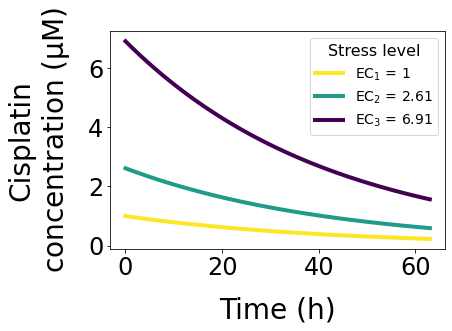

In [10]:
viridis = cm.get_cmap('viridis', 12)
print(viridis)
reps = np.linspace(0,1,3)

f = plt.figure()
plt.plot(time,out1, color = viridis(reps[2]), label = "EC$_1$ = %s" %(round(EC1,2)), linewidth = 4)
plt.plot(time,out2, color = viridis(reps[1]), label = "EC$_2$ = %s" %(round(EC2,2)), linewidth = 4)
plt.plot(time,out3, color = viridis(reps[0]), label = "EC$_3$ = %s" %(round(EC3,2)), linewidth = 4)
plt.ylabel("Cisplatin\nconcentration ($\mathrm{\mu M}$)", fontsize=28, labelpad=16)
plt.xlabel("Time (h)", fontsize=28, labelpad=16)
plt.tick_params(labelsize=24)
legend = plt.legend(title = "Stress level",fontsize = 14)
plt.setp(legend.get_title(),fontsize=16)
plt.show()
f.savefig(figOutputPath + "Fig3F_Cisplatin_decay.pdf", bbox_inches='tight')

In [11]:
# Plot the simulations of the state variables together with the data mean
plot_titles = [("$\mathrm{%s\ \mu M}$" % (str(i))) for i in doseList[0::]]

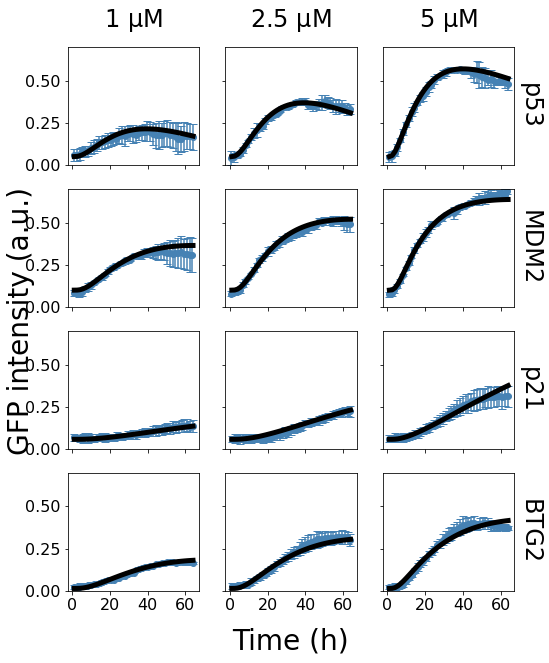

In [12]:
#############################################################################################################
# Plot 1: the simulations of the state variables together with the data mean
#############################################################################################################
fig, ax = plt.subplots(len(proteinObs), len(doseList), sharex='col', sharey='row')

begin = 0
if (len(doseList) > 1) & (len(proteinObs) > 1):
    # Plotting of multiple doses (i) and state variables (j)
    for i, dose in enumerate(doseList):
        for j, stateVar in enumerate(proteinObsNames):
            # Get the base color for the plot of this state variable
            base_col = colors.to_rgb(palette[j]) # sns.color_palette(palette[j],1)
            # Plot the data
            ax[j, i].plot(dataTimeMReal[j, begin:begin + Nt], dataMReal[j, begin:begin + Nt], 'o', label=stateVar,
                          color=base_col)
            # Plot the errorbars around the data
            ax[j, i].errorbar(dataTimeMReal[j, begin:begin + Nt], dataMReal[j, begin:begin + Nt], yerr=dataSReal[j, begin:begin + Nt],
                              capsize=4, fmt="none",
                              color=base_col)
            # Plot the model simulation
            ax[j, i].plot(dataTimePoints, mappedSimu[i, :, j], label=stateVar, color="#000000", linewidth=5)
            ax[j, len(doseList) - 1].set_ylabel(stateVar, rotation=-90, fontsize=24)
            ax[j, len(doseList) - 1].yaxis.set_label_coords(1.03, 0.5)
            ax[j, len(doseList) - 1].set_ylim(ymin = ymin, ymax = ymax)
            ax[j, i].tick_params(labelsize=16)
            ax[j, i].set_xticks(np.arange(0, list(dataTimePoints)[-1], timestep))
        begin += Nt
        ax[0, i].set_title(plot_titles[i],
                           fontdict={'fontsize': 24}, pad=20)

elif (len(doseList) == 1) & (len(proteinObs) > 1):
    # Plotting of one dose and multiple state variables (j)
    for j, stateVar in enumerate(proteinObsNames):
        # Get the base color for the plot of this state variable
        base_col = colors.to_rgb(palette[j])
        # Plot the data
        ax[j].plot(dataTimeMReal[j, begin:begin + Nt], dataMReal[j, begin:begin + Nt], 'o', label=stateVar,
                   color=base_col)
        # Plot the errorbars around the data
        ax[j].errorbar(dataTimeMReal[j, begin:begin + Nt], dataMReal[j, begin:begin + Nt], yerr=dataSReal[j, begin:begin + Nt],
                       capsize=4, fmt="none",
                       color=base_col)
        # Plot the model simulation
        ax[j].plot(dataTimePoints, mappedSimu[0, :, j], label=stateVar, color="#000000", linewidth=5)
        ax[j].set_ylabel(stateVar, rotation=-90, fontsize=24)
        ax[j].yaxis.set_label_coords(1.03, 0.5)
        ax[j].tick_params(labelsize=16)
        ax[j].set_xticks(np.arange(0, list(dataTimePoints)[-1], timestep))
    # begin += Nt
    ax[0].set_title(plot_titles[0],
                    fontdict={'fontsize': 24}, pad = 20)

elif (len(doseList) > 1) & (len(proteinObs) == 1):
    # Plotting of multiple doses (i) and one state variable
    # Get the base color for the plot of this state variable
    base_col = colors.to_rgb(palette[0])
    for i, dose in enumerate(doseList):
        # Plot the data
        ax[i].plot(dataTimeMReal[0, begin:begin + Nt], dataMReal[0, begin:begin + Nt], 'o', label=proteinObsNames[0],
                   color=base_col)
        # Plot the errorbars around the data
        ax[i].errorbar(dataTimeMReal[0, begin:begin + Nt], dataMReal[0, begin:begin + Nt], yerr=dataSReal[0, begin:begin + Nt],
                       capsize=4, fmt="none",
                       color=base_col)
        # Plot the model simulation
        ax[i].plot(dataTimePoints, mappedSimu[i, :, 0], label=proteinObs[0], color="#000000", linewidth=5)
        ax[i].tick_params(labelsize=16)
        ax[i].set_xticks(np.arange(0, list(dataTimePoints)[-1], timestep))
        begin += Nt
        ax[i].set_title(plot_titles[i],
                        fontdict={'fontsize': 24}, pad = 20)
    ax[len(doseList)-1].set_ylabel(proteinObs[0], rotation=-90, fontsize=24)
    ax[len(doseList)-1].yaxis.set_label_coords(1.03, 0.5)

else:
    # Plotting of one dose and one state variable
    # Get the base color for the plot of this state variable
    base_col = colors.to_rgb(palette[0])
    # Plot the data
    ax.plot(dataTimeMReal[0, begin:begin + Nt], dataMReal[0, begin:begin + Nt], 'o', label=proteinObsNames[0],
               color=base_col)
    # Plot the errorbars around the data
    ax.errorbar(dataTimeMReal[0, begin:begin + Nt], dataMReal[0, begin:begin + Nt], yerr=dataSReal[0, begin:begin + Nt],
                   capsize=4, fmt="none",
                   color=base_col)
    # Plot the model simulation
    ax.plot(dataTimePoints, mappedSimu[0, :, 0], label=proteinObs[0], color="#000000", linewidth=5)
    ax.set_ylabel(proteinObs[0], rotation=-90, fontsize=24)
    ax.yaxis.set_label_coords(1.03, 0.5)
    ax.tick_params(labelsize=16)
    ax.set_xticks(np.arange(0, list(dataTimePoints)[-1], timestep))
    ax.set_title(plot_titles[0],
                    fontdict={'fontsize': 24}, pad = 20)


# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
fig.subplots_adjust(hspace=0.2)
fig.set_figheight(max(10,((len(proteinObs)*2.5/1.5)+3)))
fig.set_figwidth(max(5, ((len(doseList) * 4 / 2) + 2)))
# fig.suptitle(x = 0.5, y = 0.9, t = 'Model vs. Data', fontsize=28)
fig.text(0.02, 0.5, 'GFP intensity (a.u.)', va='center', rotation='vertical', fontsize=28)

# hide tick and tick label of the big axes
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time (h)", fontsize=28, labelpad=20)
# plt.savefig(figPath + date + "_MH_" + model + "Model_parmset" + str.split(file,"_")[-2][-1] + "_modelSimulationMeanData.pdf")
#plt.savefig(figPath + date + "_MH_" + model + "Model_" + str.split(file,"_")[-3] + "_modelSimulationMeanData.pdf")
#plt.close()
plt.show()

In [13]:
viridis = cm.get_cmap('viridis', 12)
print(viridis)
reps = np.linspace(0,1,4)
viridis(reps[1])

(0.177423, 0.437527, 0.557565, 1.0)

In [14]:
from matplotlib.lines import Line2D
# Add some factor to change the colors a bit
scales = []
for l in range(1, 5):
    scales.append(l / 4)
tuples = []
for scale in scales:
    tuples.append((scale, scale, scale))

custom_lines = [Line2D([0], [0], color='k', lw=4, label='simulation'),
                Line2D([0], [0], markerfacecolor=viridis(reps[0]), marker=markers[0],color='w', markersize=15),
                Line2D([0], [0], markerfacecolor=viridis(reps[1]), marker=markers[1],color='w', markersize=15),
                Line2D([0], [0], markerfacecolor=viridis(reps[2]), marker=markers[2],color='w', markersize=15),
                Line2D([0], [0], markerfacecolor=viridis(reps[3]), marker=markers[3],color='w', markersize=15)]

# custom_lines = [Line2D([0], [0], color='red', lw=4, label='simulation'),
#                 Line2D([0], [0], markerfacecolor=tuple(l * r for l, r in zip(base_col, tuples[0])), marker=markers[0],color='w', markersize=15),
#                 Line2D([0], [0], markerfacecolor=tuple(l * r for l, r in zip(base_col, tuples[1])), marker=markers[1],color='w', markersize=15),
#                 Line2D([0], [0], markerfacecolor=tuple(l * r for l, r in zip(base_col, tuples[2])), marker=markers[2],color='w', markersize=15),
#                 Line2D([0], [0], markerfacecolor=tuple(l * r for l, r in zip(base_col, tuples[3])), marker=markers[3],color='w', markersize=15)]


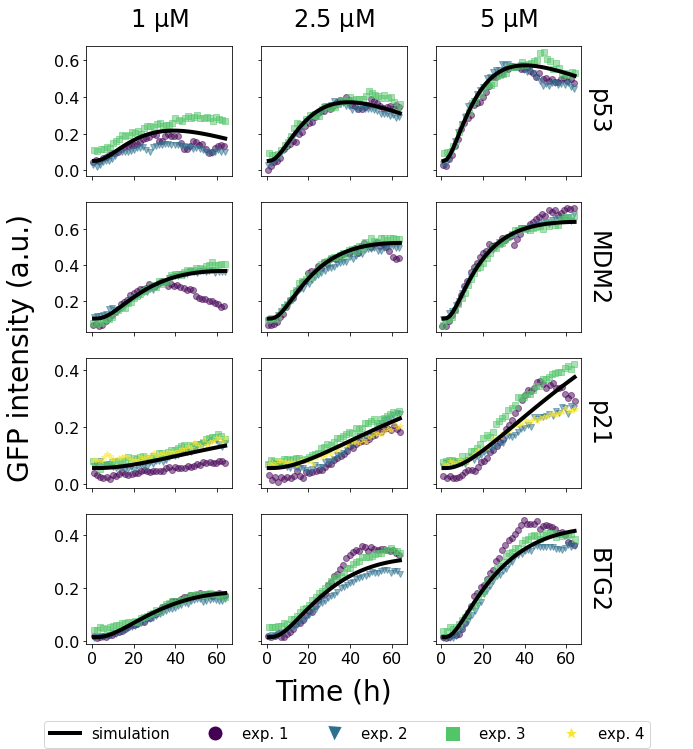

Saved ReplicateData figure


In [15]:
#############################################################################################################
# Plot 2: the simulations of the state variables together with the data per replicate
#############################################################################################################

fig, ax = plt.subplots(len(proteinObs), len(doseList), sharex='col', sharey='row')

if (len(doseList) > 1) & (len(proteinObs) > 1):
    # Plotting of multiple doses (i) and state variables (j)
    for i, dose in enumerate(doseList):
        for j, stateVar in enumerate(proteinObs):
            # Get the base color for the plot of this state variable
            base_col = colors.to_rgb(palette[j])
            # palette = sns.color_palette(palette[j],len(plateID_list[j]))
            for k, rep in enumerate(plateID_list[j]):
                numOfRepl = len(plateID_list[j])

                # Add some factor to change the colors a bit
                scales = []
                for l in range(1, numOfRepl + 1):
                    scales.append(l / numOfRepl)
                tuples = []
                for scale in scales:
                    tuples.append((scale, scale, scale))

                # Check whether there are enough markers
                if k > (len(markers) - 1):
                    warnings.warn(
                        "There are not enough markers defined to plot the data. Restarting with choosing markers at the beginning of the marker list.")
                    markers = markers + markers

                # Plot the data per replicate
                ax[j, i].plot(data[(data.timeID <= Nt) & (data.StateVar == stateVar) & (
                            data.replID == rep) & (data.dose_uMadj == doseList[i])].loc[:,
                                              realTimeColName], data[(data.timeID <= Nt) & (data.StateVar == stateVar) & (
                            data.replID == rep) & (data.dose_uMadj == doseList[i])].loc[:,
                                              realDataColName], markers[k], label=proteinObsNames[j] + ' rep ' + str(rep),
                              #color = tuple(l * r for l, r in zip(base_col, tuples[k])), alpha = 0.75)
                              color = viridis(reps[k]), alpha = 0.5)
                ax[j, i].tick_params(labelsize=16)
                ax[j, i].set_xticks(np.arange(0, list(dataTimePoints)[-1], timestep))

            # Plot the model simulations
            ax[j, i].plot(dataTimePoints, mappedSimu[i, :, j], linestyle = "solid", label=stateVar, color="#000000", linewidth=4)
            ax[j, len(doseList) - 1].set_ylabel(proteinObsNames[j], rotation=-90, fontsize=24)
            ax[j, len(doseList) - 1].yaxis.set_label_coords(1.03, 0.5)
        ax[0, i].set_title(plot_titles[i],
                           fontdict={'fontsize': 24}, pad = 20)

elif (len(doseList) == 1) & (len(proteinObs) > 1):
    # Plotting of one dose and multiple state variables (j)
    for j, stateVar in enumerate(proteinObs):
        # Get the base color for the plot of this state variable
        base_col = colors.to_rgb(palette[j])
        for k, rep in enumerate(plateID_list[j]):
            numOfRepl = len(plateID_list[j])

            # Add some factor to change the colors a bit
            scales = []
            for l in range(1, numOfRepl + 1):
                scales.append(l / numOfRepl)
            tuples = []
            for scale in scales:
                tuples.append((scale, scale, scale))

            # Check whether there are enough markers
            if k > (len(markers)-1):
                warnings.warn("There are not enough markers defined to plot the data. Restarting with choosing markers at the beginning of the marker list.")
                markers = markers + markers

            # Plot the data per replicate
            ax[j].plot(data[(data.timeID <= Nt) & (data.StateVar == stateVar) & (
                            data.replID == rep) & (data.dose_uMadj == doseList[0])].loc[:,
                                              realTimeColName], data[(data.timeID <= Nt) & (data.StateVar == stateVar) & (
                    data.replID == rep) & (data.dose_uMadj == doseList[0])].loc[:, realDataColName], markers[k],
                    label=proteinObsNames[j] + ' rep ' + str(rep),
                    color=tuple(l * r for l, r in zip(base_col, tuples[k])), alpha = 0.75) # tuple(l * r for l, r in zip(palette[j], tuples[k])))
            ax[j].tick_params(labelsize=16)
            ax[j].set_xticks(np.arange(0, list(dataTimePoints)[-1], timestep))

        # Plot the model simulations
        ax[j].plot(dataTimePoints, mappedSimu[0, :, j], label=stateVar, color="#FF0000", linewidth=3)
        ax[j].set_ylabel(proteinObsNames[j], rotation=-90, fontsize=24)
        ax[j].yaxis.set_label_coords(1.03, 0.5)
    ax[0].set_title(plot_titles[0],
                    fontdict={'fontsize': 24}, pad = 20)

elif (len(doseList) > 1) & (len(proteinObs) == 1):
    # Get the base color for the plot of this state variable
    base_col = colors.to_rgb(palette[0])
    # Plotting of multiple doses (i) and one state variable
    for i, dose in enumerate(doseList):
        for k, rep in enumerate(plateID_list[0]):
            numOfRepl = len(plateID_list[0])

            # Add some factor to change the colors a bit
            scales = []
            for l in range(1, numOfRepl + 1):
                scales.append(l / numOfRepl)
            tuples = []
            for scale in scales:
                tuples.append((scale, scale, scale))

            # Check whether there are enough markers
            if k > (len(markers)-1):
                warnings.warn("There are not enough markers defined to plot the data. Restarting with choosing markers at the beginning of the marker list.")
                markers = markers + markers

            # Plot the data per replicate
            ax[i].plot(data[(data.timeID <= Nt) & (data.StateVar == proteinObs[0]) & (
                    data.replID == rep) & (data.dose_uMadj == doseList[i])].loc[:, realTimeColName], data[(data.timeID <= Nt) & (data.StateVar == proteinObs[0]) & (
                    data.replID == rep) & (data.dose_uMadj == doseList[i])].loc[:, realDataColName], markers[k],
                       label=proteinObs[0] + ' rep ' + str(rep),
                       color=tuple(l * r for l, r in zip(base_col, tuples[k])), alpha = 0.75) # tuple(l * r for l, r in zip(palette[0], tuples[k])))
            ax[i].tick_params(labelsize=16)
            ax[i].set_xticks(np.arange(0, list(dataTimePoints)[-1], timestep))

        # Plot the model simulations
        ax[i].plot(dataTimePoints, mappedSimu[i, :, 0], label=proteinObs[0], color="#FF0000", linewidth=3)
        ax[i].set_title(plot_titles[i],
                        fontdict={'fontsize': 24}, pad = 20)
    ax[len(doseList)-1].set_ylabel(proteinObsNames[0], rotation=-90, fontsize=24)
    ax[len(doseList)-1].yaxis.set_label_coords(1.03, 0.5)

else:
    # Get the base color for the plot of this state variable
    base_col = colors.to_rgb(palette[0])
    # Plotting of one dose and one state variable
    for k, rep in enumerate(plateID_list[0]):
        numOfRepl = len(plateID_list[0])

        # Add some factor to change the colors a bit
        scales = []
        for l in range(1, numOfRepl + 1):
            scales.append(l / numOfRepl)
        tuples = []
        for scale in scales:
            tuples.append((scale, scale, scale))

        # Check whether there are enough markers
        if k > (len(markers)-1):
            warnings.warn("There are not enough markers defined to plot the data. Restarting with choosing markers at the beginning of the marker list.")
            markers = markers + markers

        # Plot the data per replicate
        ax.plot(data[(data.timeID <= Nt) & (data.StateVar == proteinObs[0]) & (
                data.replID == rep) & (data.dose_uMadj == doseList[0])].loc[:, realTimeColName], data[(data.timeID <= Nt) & (data.StateVar == proteinObs[0]) & (
                data.replID == rep) & (data.dose_uMadj == doseList[0])].loc[:, realDataColName], markers[k],
                label=proteinObs[0] + ' rep ' + str(rep),
                color=tuple(l * r for l, r in zip(base_col, tuples[k])), alpha = 0.75) # tuple(l * r for l, r in zip(palette[0], tuples[k])))
        ax.tick_params(labelsize=16)
        ax.set_xticks(np.arange(0, list(dataTimePoints)[-1], timestep))


    # Plot the model simulations
    ax.plot(dataTimePoints, mappedSimu[0, :, 0], label=proteinObs[0], color="#FF0000", linewidth=3)
    ax.set_ylabel(proteinObsNames[0], rotation=-90, fontsize=24)
    ax.yaxis.set_label_coords(1.03, 0.5)
    ax.set_title(plot_titles[0],
                    fontdict={'fontsize': 24}, pad = 20)

# add a big axes, hide frame

fig.legend(custom_lines, ('simulation','exp. 1', 'exp. 2', 'exp. 3',"exp. 4"), 
          fontsize = 15, loc = "lower center", borderaxespad=0.1, ncol = 5)#(0.9,0.5))
fig.add_subplot(111, frameon=False)
fig.subplots_adjust(hspace=0.2)
fig.text(0.025, 0.5, 'GFP intensity (a.u.)', va='center', rotation='vertical', fontsize=28)
fig.set_figheight((len(proteinObs)*2)+3) # max(10,((len(proteinObs)*2.5/1.5)+3)))
fig.set_figwidth((len(doseList) * 2) + 5) #max(5, ((len(doseList) * 4 / 2) + 3)))


# hide tick and tick label of the big axes
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time (h)", fontsize=28, labelpad = 16)
# Adjust the scaling factor to fit your legend text completely outside the plot
# (smaller value results in more space being made for the legend)
plt.subplots_adjust(right=0.75)
plt.show()

print("Saved ReplicateData figure")
fig.savefig(figOutputPath + "Fig3C_Model_and_Data.pdf", bbox_inches='tight')